In [1]:
import torch
from core.loader import build_model,build_dataset
from core.eval import mln_transitionmatrix
import numpy as np
import matplotlib.pyplot as plt
import argparse
import seaborn as sns
from core.loss import *
from dataloader.clothing1M import clothing1M
from torchvision import datasets,transforms
from PIL import Image

In [2]:
parser = argparse.ArgumentParser()
parser.add_argument('--eval',action='store_true' ,default=False,help='train or test')
parser.add_argument('--data', type=str,default='clothing1m',help='dataset',choices=["mnist",'cifar10','cifar100','trec','dirty_cifar10','dirty_mnist','clothing1m'])
parser.add_argument('--sampler', type=bool,default=False,help='for imbalanced dataset')
parser.add_argument('--batch_size', type=int,default=128,help='batch size') 
# Noise Type
parser.add_argument('--mode', type=str,default='symmetric',choices = ['symmetric','asymmetric','clean','instance'],help='Noise Pattern')
parser.add_argument('--ER', type=float,default=0.2,help='Noise Rate')

# parser.add_argument('--none',default=False,action = 'store_true',help='do not use mixtures') 
# MLN Properties
parser.add_argument('--k', type=int,default=5,help='number of mixtures') 
parser.add_argument('--sigma',default=True,action='store_false',help='use sigma attenuation term')
parser.add_argument('--sig_max', type=float,default=10,help='sig_max')
parser.add_argument('--sig_min', type=float,default=1,help='sig_min')
parser.add_argument('--ratio', type=float,default=1,help='ratio for epis')
parser.add_argument('--ratio2', type=float,default=1,help='ratio for alea')
parser.add_argument('--cross_validation', type=int,default=0,help='cross validation')
args = parser.parse_args(args=[])
device = 'cuda'

In [3]:
# plt.rc('font', family='serif')
# plt.rc('text', usetex=True)

In [4]:
Checkpoint = './ckpt/clothing1m_symmetric_0.2/MLN_12.pt'
model = build_model(args,device)

In [5]:
state_dict = torch.load(Checkpoint)
model.load_state_dict(state_dict)

<All keys matched successfully>

In [6]:
_,val_iter,_,config,_ = build_dataset(args)

In [7]:
out = mln_transitionmatrix(model,val_iter,config['input_size'],device,2,label=14)

In [8]:
TM = out['D3']
for i in range(14):
        try:
            TM[i,:]=TM[i,:]/(np.sum(TM[i,:]))
        except:
            raise
TM = np.round(TM,2)

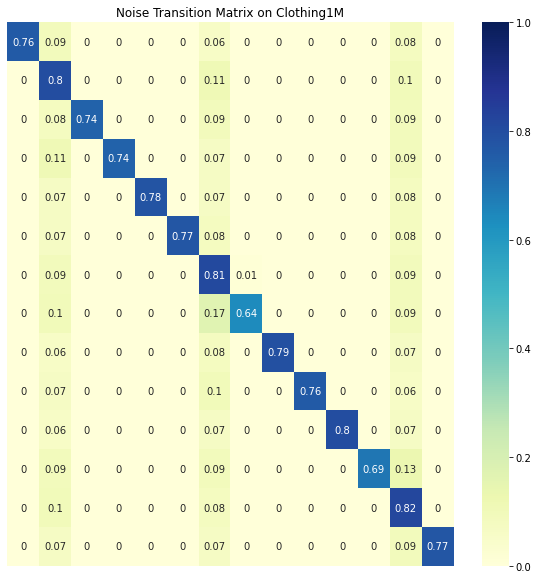

In [9]:
plt.figure(figsize=(10,10))
plt.title("Noise Transition Matrix on Clothing1M")
sns.heatmap(TM,cmap="YlGnBu", vmin=0, vmax=1,annot=True)
plt.axis('off')
plt.show()

In [10]:
sigma = out['sigma']
epis = out['epis']
log = np.zeros(14)
log2 = np.zeros(14)
for i in range(14):
    sig=sigma[str(i)]
    dist=np.asarray(sig).T

    epi=epis[str(i)]
    dist2=np.asarray(epi).T
    try:
        mean_dist=np.mean(dist)
        log[i]=mean_dist

        mean_dist2=np.mean(dist2)
        log2[i]=mean_dist2
    except:
        log[i]=0
        log2[i]=0

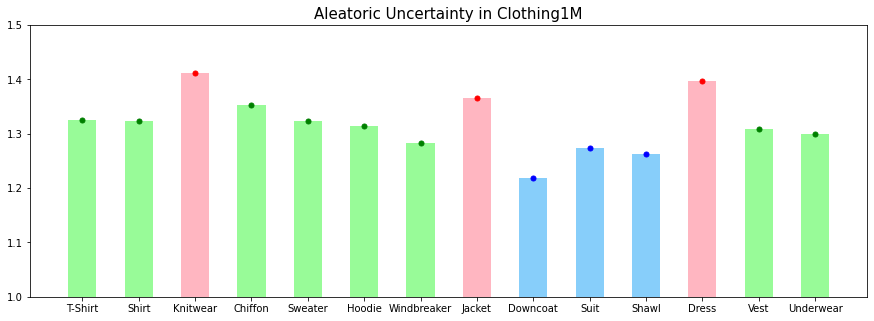

In [11]:
x=['T-Shirt',
 'Shirt',
 'Knitwear',
 'Chiffon',
 'Sweater',
 'Hoodie',
 'Windbreaker',
 'Jacket',
 'Downcoat',
 'Suit',
 'Shawl',
 'Dress',
 'Vest',
 'Underwear']
label = [i for i in range(14)]

sort_log = np.argsort(log)
top_index = sort_log[-3:]
top_log = log[top_index]
low_index = sort_log[:3]
low_log = log[low_index]
medium_index = sort_log[3:-3]
medium_log = log[medium_index]

plt.figure(figsize=(15,5))
plt.title("Aleatoric Uncertainty in Clothing1M",fontsize=15)
plt.bar(top_index,top_log, width=0.5, align='center',color='lightpink')
plt.plot(top_index,top_log,'ro',markersize=5)

plt.bar(low_index,low_log, width=0.5, align='center',color='lightskyblue')
plt.plot(low_index,low_log,'bo',markersize=5)

plt.bar(medium_index,medium_log, width=0.5, align='center', color='palegreen')
plt.plot(medium_index,medium_log,'go',markersize=5)

plt.xticks(label,x)
plt.ylim((1.0,1.5))
plt.savefig('./res/clothing1m_symmetric_0.2/class_alea.png')
plt.show()


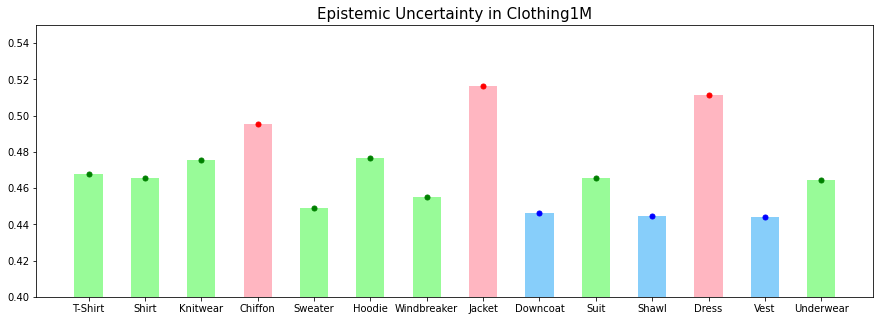

In [12]:
x=['T-Shirt',
 'Shirt',
 'Knitwear',
 'Chiffon',
 'Sweater',
 'Hoodie',
 'Windbreaker',
 'Jacket',
 'Downcoat',
 'Suit',
 'Shawl',
 'Dress',
 'Vest',
 'Underwear']
label = [i for i in range(14)]

sort_log = np.argsort(log2)
top_index = sort_log[-3:]
top_log = log2[top_index]
low_index = sort_log[:3]
low_log = log2[low_index]
medium_index = sort_log[3:-3]
medium_log = log2[medium_index]

fig = plt.figure(figsize=(15,5))
plt.title("Epistemic Uncertainty in Clothing1M",fontsize=15)
plt.bar(top_index,top_log, width=0.5, align='center',color='lightpink')
plt.plot(top_index,top_log,'ro',markersize=5)

plt.bar(low_index,low_log, width=0.5, align='center',color='lightskyblue')
plt.plot(low_index,low_log,'bo',markersize=5)

plt.bar(medium_index,medium_log, width=0.5, align='center', color='palegreen')
plt.plot(medium_index,medium_log,'go',markersize=5)

plt.xticks(label,x)
plt.ylim((0.4,0.55))
plt.savefig('./res/clothing1m_symmetric_0.2/class_epis.png')
plt.show()

In [14]:
transform_val = transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(224),
                transforms.ToTensor(),
                transforms.Normalize((0.6959, 0.6537, 0.6371),(0.3113, 0.3192, 0.3214)),
            ])
test = clothing1M(
            root        = '/home/sungjoon.choi/seungyoun/Clothing1M',
            transform   = transform_val,
            mode        = 'test')
test_iter = torch.utils.data.DataLoader(test,batch_size=args.batch_size,shuffle=False,num_workers=4)

In [15]:
model.eval()
sig = []
epi = []
id = []
label = []
pred = []
with torch.no_grad():
    for batch_in,batch_out,index in test_iter:
            mln_out     = model.forward(batch_in.view(config['input_size']).to(device))
            pi,mu,sigma = mln_out['pi'],mln_out['mu'],mln_out['sigma']
            out         = mln_gather(pi,mu,sigma)
            model_pred  = out['mu_sel'] # [B x N]
            unct_out    = mln_uncertainties(pi,mu,sigma)
            y_prob,y_pred    = torch.max(model_pred,1)
            id += index.numpy().tolist()
            pred += y_pred.cpu().numpy().tolist()
            label += batch_out.numpy().tolist()
            sig += unct_out['alea'].cpu().numpy().tolist()
            epi += unct_out['epis'].cpu().numpy().tolist()


In [16]:
sig = np.asarray(sig)
epi = np.asarray(epi)
id = np.asarray(id)
pred = np.asarray(pred)
label = np.asarray(label)

In [101]:
top_10 = np.flip(np.argsort(sig)[-16:])
top_sig = sig[top_10]
top_epi = epi[top_10]
top_pred = pred[top_10]
top_label =label[top_10]
top_index = torch.IntTensor(id[top_10])

In [102]:
low_10 = np.argsort(sig)[:16]
low_sig = sig[low_10]
low_epi = epi[low_10]
low_pred = pred[low_10]
low_label =label[low_10]
low_index = torch.IntTensor(id[low_10])

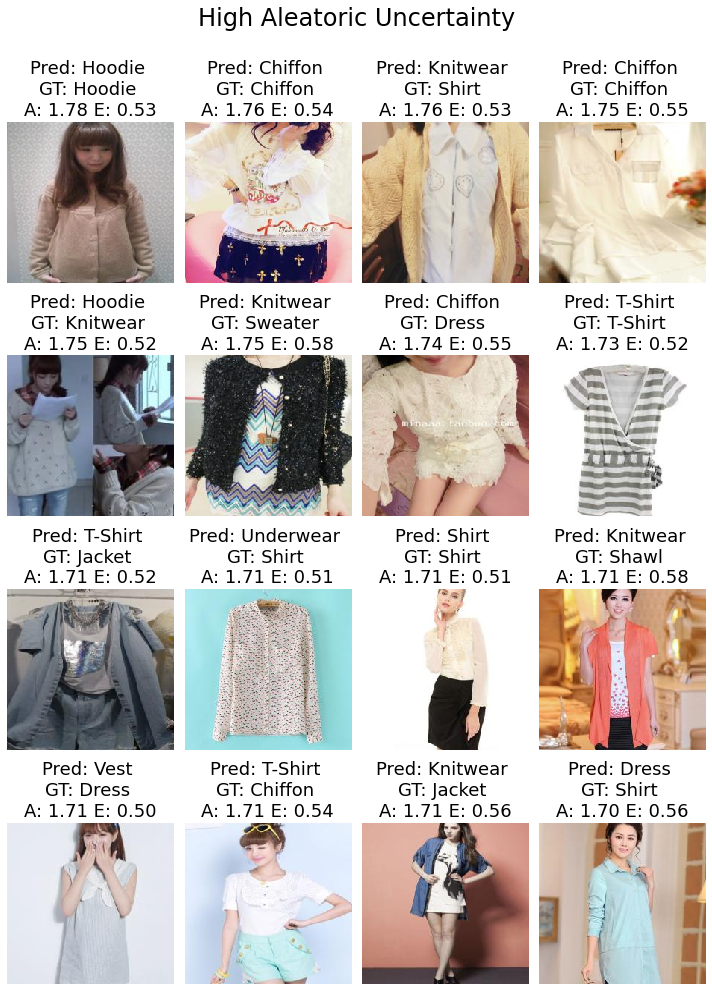

In [103]:

fig = plt.figure(figsize=(10,14))
# fig.patch.set_facecolor('white')
plt.suptitle("High Aleatoric Uncertainty\n",fontsize=24)
for i in range(16):
    img_path = test.test_imgs[top_index[i]]
    image = Image.open(img_path).convert('RGB')  
    plt.subplot(4,4,i+1)
    plt.title("Pred: %s \nGT: %s \nA: %.2f E: %.2f"
                %(x[top_pred[i]],x[top_label[i]],top_sig[i],top_epi[i])
                ,fontsize=18)
    plt.imshow(image, interpolation='nearest', aspect='auto')
    plt.axis('off')
    plt.tight_layout()
plt.savefig('./res/clothing1m_symmetric_0.2/top_alea.png')
plt.show()

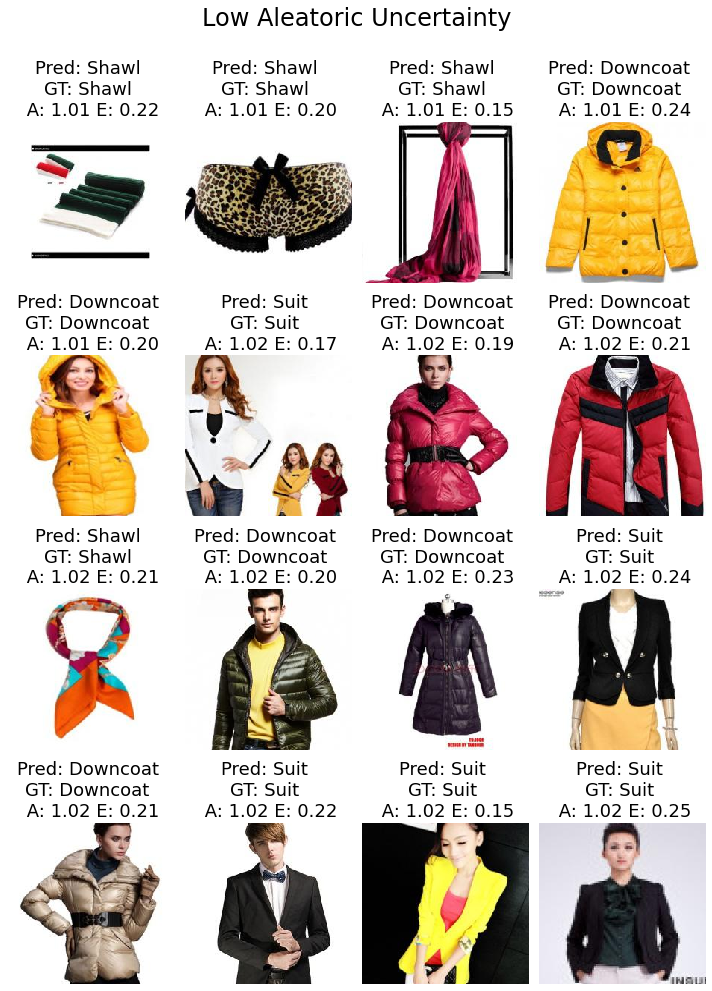

In [104]:

fig = plt.figure(figsize=(10,14))
# fig.patch.set_facecolor('white')
plt.suptitle("Low Aleatoric Uncertainty\n",fontsize=24)
for i in range(16):
    img_path = test.test_imgs[low_index[i]]
    image = Image.open(img_path).convert('RGB')  
    plt.subplot(4,4,i+1)
    plt.title("Pred: %s \nGT: %s \n A: %.2f E: %.2f"
                %(x[low_pred[i]],x[low_label[i]],low_sig[i],low_epi[i]),fontsize=18)
    plt.imshow(image,interpolation='nearest',aspect='auto')
    plt.axis('off')
    plt.tight_layout()
plt.savefig('./res/clothing1m_symmetric_0.2/low_alea.png')
plt.show()

In [105]:
top_10 = np.flip(np.argsort(epi)[-16:])
top_epi = epi[top_10]
top_sig = sig[top_10]
top_pred = pred[top_10]
top_label =label[top_10]
top_index = torch.IntTensor(id[top_10])

low_10 = np.argsort(epi)[:16]
low_epi = epi[low_10]
low_sig = sig[low_10]
low_pred = pred[low_10]
low_label =label[low_10]
low_index = torch.IntTensor(id[low_10])

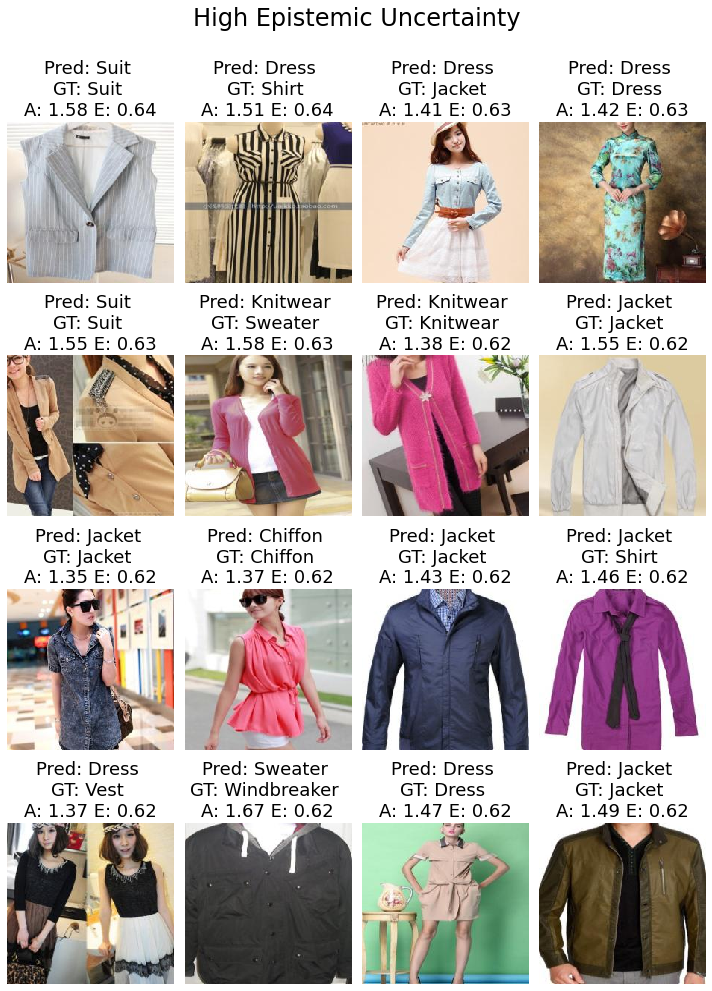

In [106]:

fig = plt.figure(figsize=(10,14))
# fig.patch.set_facecolor('white')
plt.suptitle("High Epistemic Uncertainty\n",fontsize=24)
for i in range(16):
    img_path = test.test_imgs[top_index[i]]
    image = Image.open(img_path).convert('RGB')  
    plt.subplot(4,4,i+1)
    plt.title("Pred: %s \nGT: %s \nA: %.2f E: %.2f"
        %(x[top_pred[i]],x[top_label[i]],top_sig[i],top_epi[i]),fontsize=18)
    plt.imshow(image,interpolation='nearest',aspect='auto')
    plt.axis('off')
    plt.tight_layout()
plt.savefig('./res/clothing1m_symmetric_0.2/top_epis.png')
plt.show()

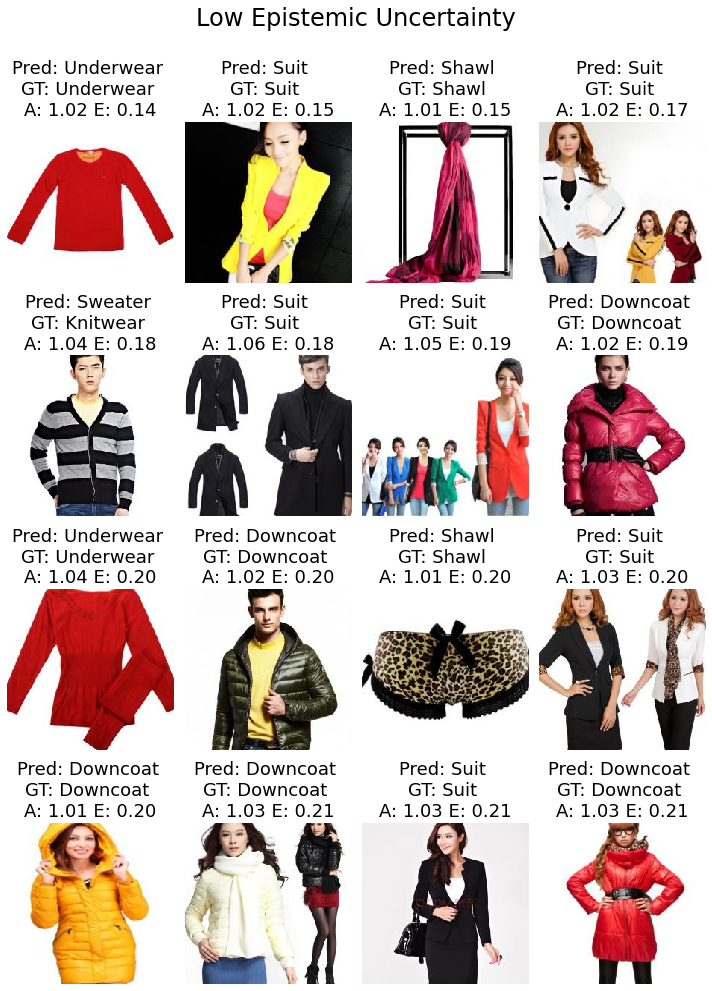

In [107]:

fig = plt.figure(figsize=(10,14))
# fig.patch.set_facecolor('white')
plt.suptitle("Low Epistemic Uncertainty\n",fontsize=24)
for i in range(16):
    img_path = test.test_imgs[low_index[i]]
    image = Image.open(img_path).convert('RGB')  
    plt.subplot(4,4,i+1)
    plt.title("Pred: %s \nGT: %s \nA: %.2f E: %.2f"%
            (x[low_pred[i]],x[low_label[i]],low_sig[i],low_epi[i]),fontsize=18)
    plt.imshow(image,interpolation='nearest',aspect='auto')
    plt.axis('off')
    plt.tight_layout()
plt.savefig('./res/clothing1m_symmetric_0.2/low_epis.png')
plt.show()

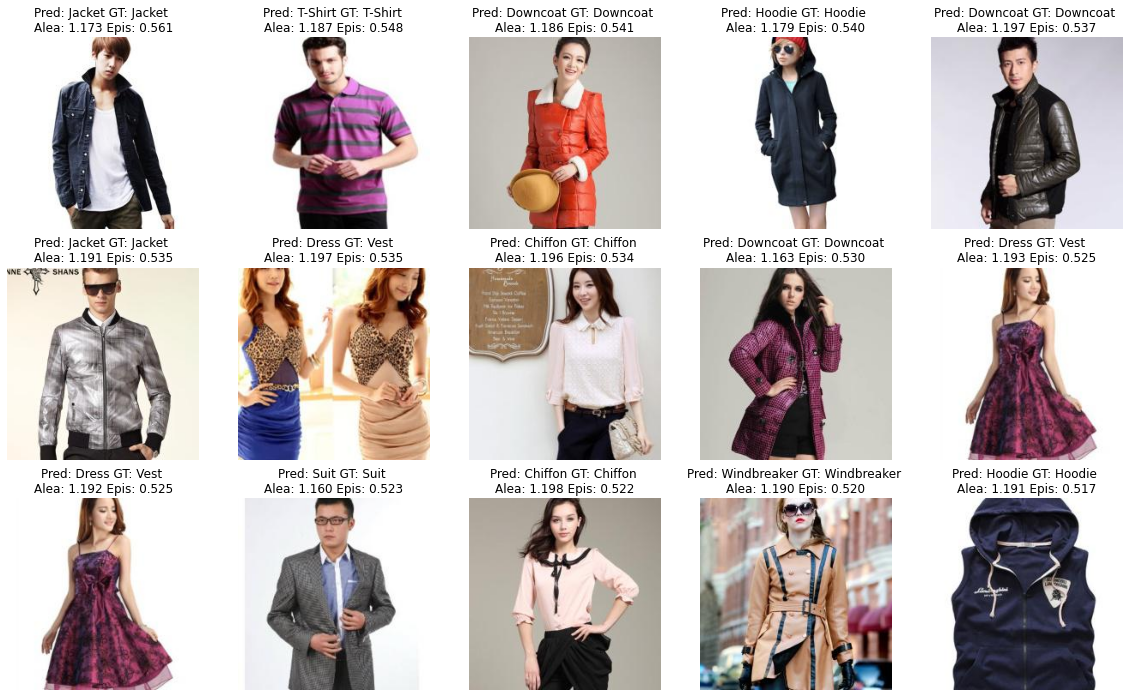

In [24]:
top_10 = np.where(sig<1.2)
top_sig = sig[top_10]
top_epi = epi[top_10]
top_pred = pred[top_10]
top_label =label[top_10]
top_index = id[top_10]

top_10 = np.flip(np.argsort(top_epi)[-15:])
top_sig = top_sig[top_10]
top_epi = top_epi[top_10]
top_pred = top_pred[top_10]
top_label =top_label[top_10]
top_index = top_index[top_10]

fig = plt.figure(figsize=(20,12))
fig.patch.set_facecolor('white')
for i in range(15):
    img_path = test.test_imgs[top_index[i]]
    image = Image.open(img_path).convert('RGB')  
    plt.subplot(3,5,i+1)
    plt.title("Pred: %s GT: %s \nAlea: %.3f Epis: %.3f"
                    %(x[top_pred[i]],x[top_label[i]],top_sig[i],top_epi[i]))
    plt.imshow(image)
    plt.axis('off')
plt.savefig('./res/clothing1m_symmetric_0.2/top_score1.png')
plt.show()

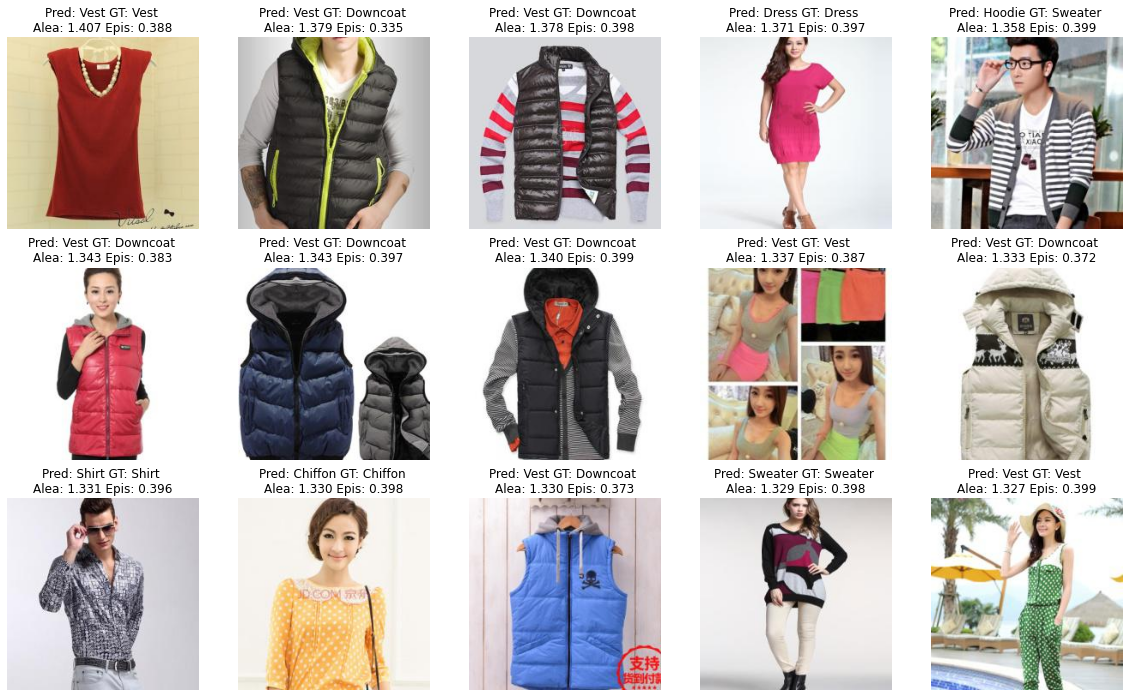

In [25]:
top_10 = np.where(epi<0.4)
top_sig = sig[top_10]
top_epi = epi[top_10]
top_pred = pred[top_10]
top_label =label[top_10]
top_index = id[top_10]

top_10 = np.flip(np.argsort(top_sig)[-15:])
top_sig = top_sig[top_10]
top_epi = top_epi[top_10]
top_pred = top_pred[top_10]
top_label =top_label[top_10]
top_index = top_index[top_10]
fig = plt.figure(figsize=(20,12))
fig.patch.set_facecolor('white')
for i in range(15):
    img_path = test.test_imgs[top_index[i]]
    image = Image.open(img_path).convert('RGB')  
    plt.subplot(3,5,i+1)
    plt.title("Pred: %s GT: %s \nAlea: %.3f Epis: %.3f"
                    %(x[top_pred[i]],x[top_label[i]],top_sig[i],top_epi[i]))
    plt.imshow(image)
    plt.axis('off')
plt.savefig('./res/clothing1m_symmetric_0.2/top_score2.png')
plt.show()